In [127]:
import math
import graphviz
from graphviz import nohtml

class Value:
    def __init__(self, data: float, _children=(), _op:str=None, label=''):
        self.data = data
        self._children = _children
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.data}, {self.label})"

    def __add__(self, other):
        out = Value(data = self.data + other.data, _children = (self, other), _op = '+')
        return out

    def __mul__(self, other):
        out = Value(data = self.data * other.data, _children = (self, other), _op = '*')
        return out

    def __truediv__(self, other):
        out = Value(data = self.data / other.data, _children=(self, other), _op = '/')
        return out

    def tan(self):
        tan_val = (math.exp(self.data ** 2) - 1)/(math.exp(self.data**2) +1)
        out = Value(data =  tan_val, _children=( self ), _op='tan')
        return out


In [128]:
a = Value(data=2.0, label='a')
b = Value(data=3.0, label='b')
print(a)
c = a*b; c.label='c'
print(c)
d = Value(8.0, label='d')
e = d/c; e.label='e'
print(e)

Value(2.0, a)
Value(6.0, c)
Value(1.3333333333333333, e)


Value(1.3333333333333333, e)
Value(6.0, c)
Value(3.0, b)
Value(2.0, a)
Value(8.0, d)
[]


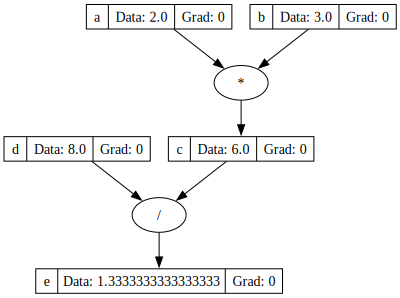

In [130]:

def draw_graph(parent: Value):
    f = graphviz.Digraph(node_attr={'shape': 'record', 'height': '.1'})
    stack = [parent];
    f.node(parent.label,nohtml(f'<f0> {parent.label} |<f1> Data: {parent.data}|<f2>Grad: {0}'))
    while len(stack)!=0:
        cur = stack.pop()
        print(cur)
        if cur._op != None :
            f.node(cur.label+cur._op, cur._op,shape='oval')
            f.edge(cur.label+cur._op, cur.label)
        if cur._children is not None:
            for children in cur._children:
                f.node(children.label,nohtml(f'<f0> {children.label} |<f1> Data: {children.data}|<f2>Grad: {0}'))
                if cur._op != None :
                    f.edge(children.label, cur.label+cur._op)
                stack.append(children)
    return f

draw_graph(e)
